In [1]:
using Plots, StatsBase, LinearAlgebra, Statistics, JLD2, Dates, StaticArrays, JSON, CUDA

# data structure module
# include("spin_sim_functions.jl")
# using .spin_sim_functions

# function libraries
# include("spin_sims_new.jl");

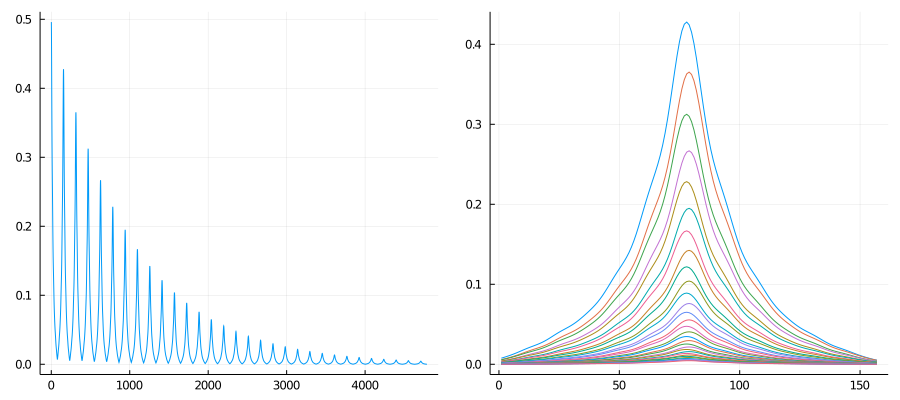

In [2]:
M_list_big = Array{Any}(undef, 14)
echoes_big = Array{Any}(undef, 14)

for i = 1:14
    str1 = "cpmg_vary_α_0_vary_te_M_list_1_"*string(i)*".jld2"
    str2 = "cpmg_vary_α_0_vary_te_echoes_1_"*string(i)*".jld2"
    
    @load str1 M_list
    @load str2 echoes
    
    M_list_big[i] = M_list
    echoes_big[i] = echoes
end

idx = 1
p1 = plot(leg = false)
plot!(p1, broadcast(abs, M_list_big[idx]))
p2 = plot(leg = false)

echoes_to_plot = echoes_big[idx]
for i = 1:size(echoes_to_plot,1)
    plot!(p2, broadcast.(abs, echoes_to_plot[i,:]))
end

plt = plot(p1, p2, size = (900, 400))
display(plt)

In [2]:
## CURRENTLY ONLY SET UP FOR PERIODIC BOUNDARY CONDITIONS

# module spin_sim_functions

using StaticArrays
using StatsBase
using Random, Distributions
using LinearAlgebra
using CUDA

## MAKE DICTIONARY OF INDEPENDENT VARIABLES
function make_params(α, n, bw = 0.5, γ = 2*pi*1e6, τ = 50e-6, dt = 2, ψ_0 = @SArray[1; 0], ν0 = 10)

    f = Dict();

    # magnetization
    f["Ix"] = convert.(Complex{Float32}, @SArray [0 1/2; 1/2 0]);
    f["Iy"] = convert.(Complex{Float32}, @SArray [0 -1im/2; 1im/2 0]);
    f["Iz"] = convert.(Complex{Float32}, @SArray [1/2 0; 0 -1/2]);
    f["Ip"] = f["Ix"] + 1im*f["Iy"];
    f["Im"] = f["Ix"] - 1im*f["Iy"];
    f["M_op"] = f["Ip"];

    # pulse operators
    f["U90"] = convert.(Complex{Float32}, exp(-1im*pi*f["Ix"]/2));

    # time variables
    f["γ"] = convert.(Float32, γ);
    f["τ"] = convert.(Float32, τ);
    f["dt"] = convert.(Float32, dt);

    # interaction variables
    f["α"] = convert.(Float32, α);

    # spin ensemble variables
    f["ν0"] = convert.(Float32, ν0);
    f["bw"] = convert.(Float32, bw);
    f["n"] = n;
    f["integrated_sampling"] = false;
    f["tiles"] = false;

    # initial condition
    f["ψ0"] = convert.(Complex{Float32}, ψ_0);

    # correlation length, off by default
    f["local_M_on"] = true;

    # dissipation, off by default
    f["dissipation"] = true;

    return f

end

## MAKE TEMPORARY params DICTIONARY FOR A GIVEN ITERATION AND CALCULATE DEPENDENT VARIABLES
function make_temp_params(params, vars, I)

    # copy the parameter file
    f = copy(params);

    # reassign loop variables based on iteration
    num_idx_assign = 0;
    tupI = ()
    for idx_l = 1:length(I)
        tupI = (tupI..., I[idx_l])
    end

    for v in vars
        if typeof(v) == String
            idx = findall(y -> y == v, vars)[1];
            temp = f[v];
            f[v] = temp[I[idx]];
            num_idx_assign += 1 
        else
            L = length.(v)
            idx = findall(y -> y == v, vars)[1];
            if maximum(L)[1] > 1 && [typeof(x) == String for x in v] != [true for x in v]
                idx_h = tupI[(num_idx_assign+1):(num_idx_assign+maximum(L)[1])]
                temp = f[v[1]]
                f[v[1]] = temp[idx_h...]
                x = v[2]
                for idx_x = 1:length(x)
                    temp = f[x[idx_x]]
                    f[x[idx_x]] = temp[idx_h[idx_x]]
                end
                num_idx_assign += maximum(L)[1]
            else    
                for x in v
                    temp = f[x];
                    f[x] = temp[I[idx]];
                end
                num_idx_assign += 1
            end
        end
    end

    ## calculate dependent variables ##

    # set some dependent defaults (for spatial variation, there's probably a general way to do this)
    n = f["n"]
    if ~haskey(f, "r")
        if length(n) == 1
            f["k"] = [0];
            f["r"] = fill(0, n)
            f["spin_idx"] = [(i) for i = 1:n[1]]
        elseif length(n) == 2
            f["k"] = [0; 0];
            f["r"] = fill([0; 0], n)
            f["spin_idx"] = [(i, j) for i = 1:n[1], j = 1:n[2]]
        else
            f["k"] = [0; 0; 0];
            f["r"] = fill([0; 0; 0], n)
            f["spin_idx"] = [(i, j, k) for i = 1:n[1], j = 1:n[2], k = 1:n[3]]
        end
    end

    # number of points in time
    f["nτ"] = convert(Int64, round(f["τ"]*f["γ"]/f["dt"]));

    # number of frequencies
    f["nfreq"] = prod(f["n"]);

    ## INTEGRATED SAMPLING
    if f["integrated_sampling"]

        ## TILING, IF NEEDED
        if f["tiles"]

            # create the tile distributions
            tile_ν = collect(LinRange(f["ν0"] - f["bw"]/2, f["ν0"] + f["bw"]/2, prod(f["tile_dims"])))
            tile_P = lorentzian.(tile_ν, f["ν0"], 0.05)/sum(lorentzian.(tile_ν, f["ν0"], 0.05))

            # make the tiles
            big_ν, big_P = make_freq_tiles(tile_ν, tile_P, f["n"], f["tile_dims"])

            f["ν"] = big_ν
            f["P"] = big_P
            f["ψ_init"] = fill(f["ψ0"], f["n"])

        else

            ν = collect(LinRange(f["ν0"] - f["bw"]/2, f["ν0"] + f["bw"]/2, f["nfreq"]))
            P = lorentzian.(ν, f["ν0"], 0.05)/sum(lorentzian.(ν, f["ν0"], 0.05))

            f["ν"] = reshape(ν, f["n"])
            f["P"] = reshape(P, f["n"])
            f["ψ_init"] = fill(f["ψ0"], f["n"]);

        end

    else

        ## DISCRETE SAMPLING
        x = collect(LinRange(f["ν0"] - f["bw"]/2, f["ν0"] + f["bw"]/2, f["nfreq"]))
        f["ν"] = convert.(Complex{Float32}, sample(x, Weights(lorentzian.(x, f["ν0"], 0.05)), f["n"]))
        f["P"] = convert.(Complex{Float32}, fill(1/prod(f["n"]), f["n"]))
        f["ψ_init"] = fill(f["ψ0"], f["n"])

    end

    # calculate dissipation jump operators, if needed
    if f["dissipation"]

        Γ = f["Γ"]

        Ljs = [];
        push!(Ljs, sqrt(Γ[1])*f["Ip"])
        push!(Ljs, sqrt(Γ[2])*f["Im"])
        push!(Ljs, sqrt(Γ[3])*f["Iz"])

        f["Lj"] = Ljs;

    end

    return f

end

## MAKE A LATTICE
function make_lattice(hlk, θ, n, pbc)

    npts = prod(n)

    # calculate the dimension of the lattice
    dim = size(hlk, 1)

    # zero fill the θ and hlk arrays and fill out n array with 1s
    hlk_h = copy(hlk)
    θ_h = copy(θ)
    n_h = tuple(copy(collect(n))...) # i hate tuples

    while size(hlk_h, 1) < 3
        push!(hlk_h, 0)
        n_h = (n_h..., 1)
    end
    while size(θ_h, 1) < 3
        push!(θ_h, 0)
    end

    # calculate coordinates
    f = sample(1:npts, n, replace = false)
    idx_list = [findall(x -> x == temp, f)[1] for temp in f]

    # array to save positions
    r = Array{Any}(undef, n)
    spin_idx = Array{Any}(undef, n)

    # calculate positions
    for idx in idx_list

        # have to retrieve individual values from idx (bc of stupid cartesianindex types)
        n_idx = [];
        for idx_h = 1:length(idx)
            push!(n_idx, idx[idx_h])
        end

        # fill it out with ones for the unit dimensions
        while length(n_idx) < 3
            push!(n_idx, 1)
        end

        # assign local indices based on periodic or non periodic bc
        if pbc
            x_idx = mod(n_idx[1] - 1 + n_h[1]/2, n_h[1]) - n_h[1]/2
            y_idx = mod(n_idx[2] - 1 + n_h[2]/2, n_h[2]) - n_h[2]/2
            z_idx = mod(n_idx[3] - 1 + n_h[3]/2, n_h[3]) - n_h[3]/2
        else
            x_idx = n_idx[1] - 1
            y_idx = n_idx[2] - 1
            z_idx = n_idx[3] - 1
        end

        # calculate the positions
        x = x_idx*hlk_h[1] + y_idx*hlk_h[2]*cos(θ_h[1]) + z_idx*hlk_h[3]*cos(θ_h[2])*sin(θ_h[3])
        y = y_idx*hlk_h[2]*sin(θ_h[1]) + z_idx*hlk_h[3]*sin(θ_h[2])*sin(θ_h[3])
        z = z_idx*hlk_h[3]*cos(θ_h[3])

        # assign only the non unit dimensions
        temp_r = [x, y, z]
        temp_idx = (n_idx[1], n_idx[2], n_idx[3])
        r[idx] = temp_r[1:dim]
        spin_idx[idx] = temp_idx[1:dim]

    end

    return r, spin_idx

end

## DIVIDE LATTICE INTO TILES
function make_freq_tiles(ν, P, n, tile_dims)

    # to hold the frequencies
    big_ν = Array{Any}(undef, n)
    big_P = Array{Any}(undef, n)

    # size of the tiles in each direction
    tile_dims = (10, 10)

    # calculate the number of times in each direction
    n_h = copy(collect(n))
    num_tiles = tuple(convert.(Int64, n_h./tile_dims)...)

    # create some coordinates
    f = sample(1:prod(num_tiles), num_tiles, replace = false)
    idx_list = [findall(y -> y == x, f)[1] for x in f]

    for idx in idx_list

        # convert to non cartesian index
        tile_coord = []
        for ii = 1:length(idx)
            push!(tile_coord, idx[ii])
        end

        n0 = (tile_coord .- 1).*tile_dims .+ 1
        nf = tile_coord.*tile_dims

        # get subspace of frequency mesh from n0, nf-- couldn't think of a better way to do it for varying length(n), alas
        if length(n) == 1
            temp_idx = collect(convert.(Int64, round.(LinRange(n0[1], nf[1], tile_dims[1]))))
        elseif length(n) == 2
            temp_idx_x = collect(convert.(Int64, round.(LinRange(n0[1], nf[1], tile_dims[1]))))
            temp_idx_y = collect(convert.(Int64, round.(LinRange(n0[2], nf[2], tile_dims[2]))))
            temp_idx = [(temp_idx_x[i], temp_idx_y[j]) for i = 1:tile_dims[1], j = 1:tile_dims[2]]
        else
            temp_idx_x = collect(convert.(Int64, round.(LinRange(n0[1], nf[1], tile_dims[1]))))
            temp_idx_y = collect(convert.(Int64, round.(LinRange(n0[2], nf[2], tile_dims[2]))))
            temp_idx_z = collect(convert.(Int64, round.(LinRange(n0[3], nf[3], tile_dims[3]))))
            temp_idx = [(temp_idx_x[i], temp_idx_y[j], temp_idx_z[k]) for i = 1:tile_dims[1], j = 1:tile_dims[2], k = 1:tile_dims[3]]
        end

        # fill with spin sampling
        shuff = sample(1:prod(tile_dims), length(ν), replace = false)
        temp_ν = ν[shuff]
        temp_P = P[shuff]
        idx3 = 1
        for idx2 in temp_idx
            big_ν[idx2...] = temp_ν[idx3]
            big_P[idx2...] = temp_P[idx3]
            idx3 += 1
        end

    end

    # normalize big_P
    big_P = big_P./prod(num_tiles)

    return big_ν, big_P

end

## MAKE INDICES FOR GENERALIZED for LOOP
function make_idx(vars, params)

    # create the tuple with the dimensions needed
    d = ();

    if isempty(vars)

        d = (1)
        f = [1]
        I = [findall(x -> x == temp, f)[1] for temp in f]

    else

        for v in vars

            # check for paired variables
            if typeof(v) == String
                f = params[v]
                lf = size(f,1)
                d = (d..., lf)
            else
                L = length.(v)
                # check variables that depend on more than one other variable
                if maximum(L)[1] > 1 && [typeof(x) == String for x in v] != [true for x in v]
                    x = v[1]
                    f = params[x]
                    lf = size(f)
                    for lx in lf
                        d = (d..., lx)
                    end
                else
                    x = v[1];
                    f = params[x]
                    lf = size(f,1)
                    d = (d..., lf)
                end
            end
        end               

        # create array where element = index of element
        f = sample(1:prod(d), d, replace = false)
        I = [findall(x -> x == temp, f)[1] for temp in f]

    end

    return I, d

end

## MAKE STENCIL
function make_stencil(hlk, θ, n, r, ξ, pbc, p)

    if pbc

        # calculate the stencil
        stencil = zeros(Float64, size(r))
        for temp_r in r
            idx = findall(y -> y == temp_r, r)[1]
            stencil[idx] = 1/((norm(temp_r)/ξ)^p + 1)
        end

        # set self coupling to zero
        stencil[1,1] = 0;

    else

        # making 4 tiles of the lattice
        new_n = tuple(collect(2 .*n)...)

        # make a lattice 4x the size
        r_h, spin_idx_h = make_lattice(hlk, θ, new_n, true)

        # calculate the stencil
        stencil = zeros(Float64, size(r_h))
        for temp_r in r_h
            idx = findall(y -> y == temp_r, r_h)[1]
            stencil[idx] = 1/(norm(temp_r)/ξ + 1)
        end

    end

    return stencil

end

function make_sparse_stencil(r, ξ, n, p, t1, t2, d_pow, d_coeff)

    # calculate the stencil with zeros
    stencil = zeros(Float64, size(r))
    for temp_r in r
        idx = findall(y -> y == temp_r, r)[1]
        temp = 1/((norm(temp_r)/ξ)^p + 1)
        if temp < t1
            temp = 0
        end
        stencil[idx] = temp;
    end


    # find all the zero points in the array
    z_pts = findall(y -> y == 0, stencil)

    # find all the non-zero points in the array
    nz_pts = findall(y -> y != 0, stencil)

    # initialize the distances as very large
    d = 1000000*ones(size(r))

    # initialize the value of the nearest point as zero
    val = zeros(size(r))

    # check each of the zero points in the array
    for z_idx in z_pts

        # scan all the non-zero poitns
        for nz_idx in nz_pts

            # change the value of d here to zero
            d[nz_idx] = 0

            # compute the distance between the zero point and non zero point
            new_d = norm(r[z_idx] - r[nz_idx])

            # if it is closer, replace the former value
            if new_d < d[z_idx]
                d[z_idx] = new_d
                val[z_idx] = stencil[nz_idx]
            end
        end

        r_val = exp(-(d_coeff*d[z_idx])^d_pow)*val[z_idx]
        if r_val > t2
            stencil[z_idx] = r_val
        end

    end

    stencil[1,1] = 0

    # stencil = sparse(stencil)
    return stencil

 end

## CHECK FOR PERIODIC BOUNDARY CONDITIONS AND DO THE SHIFT
function shift_stencil_pbc(stencil, P, spin_idx, n)

    stencil = CuArray(stencil)
    bigS = CUDA.zeros(n[1], n[2], n[1], n[2])

    for v in spin_idx
        shift = (spin_idx[v...][1] - 1, spin_idx[v...][2] - 1)
        temp = P.*circshift(stencil, shift)
        bigS[:,:,v[1],v[2]] = temp/sum(temp)
    end

    return bigS

end   

## OLD ## CHECK FOR PERIODIC BOUNDARY CONDITIONS AND DO THE SHIFT
function shift_stencil(stencil, P, spin_idx, n, pbc)

    # shift based on the current spin  
    stencil_h = circshift(copy(stencil), spin_idx)

    # if using the big_stencil approach, take only the correct subspace of the big stencil
    if ~pbc

        # conditionals cuz idk how else to do it
        if length(n) == 1 
            return stencil_h[1:n[1]] 
        elseif length(n) == 2
            return stencil_h[1:n[1],1:n[2]] 
        else
            return stencil_h[1:n[1],1:n[2],1:n[3]]
        end

    # otherwise just spit it back
    else

        return stencil_h

    end

end   

## CUSTOM DISTRIBUTIONS
function lorentzian(x, μ, Γ)
    L = (1/π)*(Γ/2)/((x-μ)^2+(Γ/2)^2)
    return L
end

function gaussian(x,μ,σ)
    G = (1/(σ*sqrt(2*pi)))*exp(-(1/2)*((x.-μ)/σ).^2)
    return G
end

#     export lorentzian, gaussian
#     export make_params, make_temp_params, make_lattice, make_freq_tiles, make_idx, make_stencil, make_sparse_stencil, shift_stencil_pbc

# end

gaussian (generic function with 1 method)

In [3]:
## ONLY WORKS FOR BOTH DISSIPATION AND LOCAL M

include("liouville_tools.jl")
using .LiouvilleTools
using LinearAlgebra
using CUDA

function spin_echo_sim(params)
    
    # initialize M_list
    M_list = [];
    
    U90 = params["U90"];
    
    # 90 pulse
    ψ_list = [U90*ψ for ψ in params["ψ_init"]];
    
    # first tau
    t0 = 0.0;
    ψ_list, M_list, t1 = time_propagate(ψ_list, M_list, t0, params["dt"], params["nτ"], params)
    
    # 180 pulse
    ψ_list = [U90*U90*ψ for ψ in ψ_list];
        
    # second tau
    ψ_list, M_list, t2 = time_propagate(ψ_list, M_list, t1, params["dt"], 2*params["nτ"], params)
    
  return M_list

end

function time_propagate(ψ_list, M_list, t0, dt, nsteps, params)
        
    # spectrum info
    ν0 = params["ν0"] # central freq.
    ν = params["ν"] # spin freqs.
    P = CuArray(params["P"]) # spin weights
    nS = params["nfreq"] # number of spins
    r = params["r"] # positions of spins
    
    # operators
    M_op = params["M_op"]
    Iz = params["Iz"]
    
    # additional values
    n = params["n"]
    pbc = params["pbc"]
    spin_idx = params["spin_idx"]
    
    # experiment parameters
    α = params["α"]
    
    # initial time
    t = t0;

    # initial magnetization    
    M_eval = [tr(M_op*ψ*ψ') for ψ in ψ_list]
    M_eval = CuArray(M_eval)
    M = sum(P.*M_eval);
    
    # prepare the stencils
    M_stencil = params["M_stencil"]
    M_stencil_vec = shift_stencil_pbc(M_stencil, P, spin_idx, n)

    # calculate the local magnetization ### HAVE TO FIX FOR DIFF DIMENSION MESHES
    M_eval = repeat(M_eval, 1, 1, n[1], n[2])
    M_eval .*= M_stencil_vec # multiply
    M_local = mapreduce(identity, +, M_eval; dims = [1,2])
    M_local = dropdims(M_local, dims = (1,2))
    
    # time evolve
    for idx = 1:nsteps
        
        t += dt;
            
        # convert to array type
        M_local = Array(M_local)

        # calculate interaction
        Oprime = map(x -> (1/4)*[0 conj(x); x 0] - (1/4)*[0 x*exp(-2im*ν0*t); conj(x)*exp(2im*ν0*t) 0], M_local)
        int = α*Oprime

        # calculate propagators
        H = -(ν.-ν0).*[Iz] .- int
        U = map(exp, -1im*H*dt)
        
        # time evolve
        ψ_list = U.*ψ_list;
        
        # calculate local M, convert to CuArray type
        M_eval = [tr(M_op*ψ*ψ') for ψ in ψ_list]
        M_eval = CuArray(M_eval)
        
        # calculate global M and save
        M = sum(P.*M_eval);
        push!(M_list, M);

        # local Magnetization update ### HAVE TO FIX FOR DIFF DIMENSION MESHES
        M_eval = repeat(M_eval, 1, 1, n[1], n[2])
        M_eval .*= M_stencil_vec # multiply
        M_local = mapreduce(identity, +, M_eval; dims = [1,2])
        M_local = dropdims(M_local, dims = (1,2))
                
    end
    
    return ψ_list, M_list, t
    
end

function spin_echo_sim_liouville(params)   
    
    # initialize M_list
    M_list = [];
    
    UL90 = params["U90"];
    UR90 = UL90'
    
    # 90 pulse
    ψ_list = [UL90*ψ for ψ in params["ψ_init"]];
    
    # convert to liouville space
    ρ_list_L = [dm_H2L(ψ*ψ') for ψ in ψ_list];    
    
    # first tau
    t0 = 0.0;
    ρ_list_L, M_list, t1 = time_propagate_liouville(ρ_list_L, M_list, t0, params["dt"], params["nτ"], params)
    
    # 180 pulse
    ρ_list_L = [dm_H2L(UL90*UL90* dm_L2H(ρ_L) *UR90*UR90) for ρ_L in ρ_list_L];
        
    # second tau
    ρ_list_L, M_list, t2 = time_propagate_liouville(ρ_list_L, M_list, t1, params["dt"], 2*params["nτ"], params)
    
  return M_list

end

function time_propagate_liouville(ρ_list_L, M_list, t0, dt, nsteps, params) 
            
    # spectrum info
    ν0 = params["ν0"] # central freq.
    ν = params["ν"] # spin freqs.
    P = CuArray(params["P"]) # spin weights
    nS = params["nfreq"] # number of spins
    
    # operators
    M_op = params["M_op"]
    Iz = params["Iz"]
    
    # additional values
    n = params["n"]
    pbc = params["pbc"]
    spin_idx = params["spin_idx"]
    
    # interaction parameters
    α = params["α"]
    
    # initial time
    t = t0;

    # jump operators
    Lj_list = params["Lj"]
    J_L = JumpsToSuper(Lj_list) # get dissipative super operator (assumed constant in time)
  
    # initial magnetization    
    M_L = leftop_H2L(M_op)
    M_eval = [tr_L(M_L*ρ) for ρ in ρ_list_L]
    M_eval = CuArray(M_eval)
    M = sum(P.*M_eval);

    # prepare the stencils
    M_stencil = params["M_stencil"]
    M_stencil_vec = shift_stencil_pbc(M_stencil, P, spin_idx, n)

    # calculate the local magnetization ### HAVE TO FIX FOR DIFF DIMENSION MESHES
    M_eval = repeat(M_eval, 1, 1, n[1], n[2])
    M_eval .*= M_stencil_vec # multiply
    M_local = mapreduce(identity, +, M_eval; dims = [1,2])
    M_local = dropdims(M_local, dims = (1,2))
    
    # time evolve
    for idx = 1:nsteps
        
        t += dt;
        
        # convert to array type
        M_local = Array(M_local)
        
        # calculate interaction
        int = α*map(x -> (1/4)*[0 conj(x); x 0] - (1/4)*[0 x*exp(-2im*ν0*t); conj(x)*exp(2im*ν0*t) 0], M_local)
        
        # calculate hamiltonian
        H_H = -(ν.-ν0).*[Iz] .- int
        H_L = [HamToSuper(H) for H in H_H]
        
        # calculate propagators, adding in dissipation
        U_L = [exp(( -1im*H + J_L )*dt) for H in H_L]
        
        # time evolve
        ρ_list_L = U_L.*ρ_list_L
        
        # update M and save value
        M_eval = [tr_L(M_L*ρ) for ρ in ρ_list_L]
        M_eval = CuArray(M_eval)
        M = sum(P.*M_eval);
        push!(M_list, M)

        # local Magnetization update ### HAVE TO FIX FOR DIFF DIMENSION MESHES
        M_eval = repeat(M_eval, 1, 1, n[1], n[2])
        M_eval .*= M_stencil_vec # multiply
        M_local = mapreduce(identity, +, M_eval; dims = [1,2])
        M_local = dropdims(M_local, dims = (1,2))
        
    end
        
    return ρ_list_L, M_list, t
    
end


function getOprime(t, M, params)
    
    # interaction parameters
    ν0 = params["ν0"]
    
    # Oprime = (1im/2)*[0 -exp(-1im*ν0*t); exp(1im*ν0*t) 0]; # Iy
    Oprime = [(1/4)*[0 conj(x); x 0] - (1/4)*[0 x*exp(-2im*ν0*t); conj(x)*exp(2im*ν0*t) 0] for x in M]; # IyMy
    # Oprime = (1im/4)*[0 -conj(M); M 0] + (1im/4)*[0 -M*exp(-2im*ν0*t); conj(M)*exp(2im*ν0*t) 0]; # IyMx
    # Oprime = (1im/4)*[0 conj(M); -M 0] + (1im/4)*[0 -M*exp(-2im*ν0*t); conj(M)*exp(2im*ν0*t) 0]; # IxMy
    # Oprime = (1/4)*[0 conj(M); M 0] + (1/4)*[0 M*exp(-2im*ν0*t); conj(M)*exp(2im*ν0*t) 0]; #IxMx
    
    return Oprime
    
end

getOprime (generic function with 1 method)

# SET VARIABLES

In [4]:
# interaction
#= α = round.(collect(LinRange(0.05, 0.2, 16)), digits = 2)
pushfirst!(α, 0)
=#
α = 0;

# number of frequencies
n = (100, 100)

# make the parameter file
params = make_params(α, n);

# make a lattice, pbc = periodic bc or not
hlk = [1; 1]
θ = [π/2]
pbc = true;
r, spin_idx = make_lattice(hlk, θ, n, pbc);
params["spin_idx"] = spin_idx
params["pbc"] = pbc

# make the stencil
# ξ = correlation length, (hlk, θ, n, r) = lattice parameters, pbc = periodic bc or not, p = decay pow (1/r^p)
# for sparse: t1 = threshold for starting decay, t2 = cutoff to go to zero, cutoff = exp(-(d_coeff*r)^d_pow)
t1 = 0.1
t2 = 0.001
d_pow = 2
d_coef = 0.5
ξ = 10;
p = 4;
# stencil = make_stencil(hlk, θ, n, r, ξ, pbc, p);
stencil = make_sparse_stencil(r, ξ, n, p, t1, t2, d_pow, d_coef)
params["M_stencil"] = stencil;
params["ξ"] = ξ

# load dissipation parameters
Γ = (0, 0, 10^-3);
params["Γ"] = Γ

#= load the pulsing parameters
f = LinRange(0.1, 1, 15)
Ix = convert.(Complex{Float32}, @SArray [0 1/2; 1/2 0])
U90 = ()
for f_temp in f
    U90_temp = convert.(Complex{Float32}, exp(-1im*pi*f_temp*Ix/2));
    U90 = (U90..., U90_temp)
end
params["U90"] = U90
=#

#= load τ list
τ = exp10.(LinRange(-5, -3, 15));
params["τ"] = τ; =#

(0, 0, 0.0010000000000000002)

In [137]:
using SparseArrays
using BenchmarkTools

M_eval = rand(n[1],n[2]);
s_stencil = sparse(stencil);

cM_eval = CuArray(M_eval)
c_stencil = CuArray(stencil)
c_d_stencil = CuArray(d_stencil)

In [141]:
@benchmark M_eval.*d_stencil

BenchmarkTools.Trial: 
  memory estimate:  19.69 KiB
  allocs estimate:  4
  --------------
  minimum time:     5.367 μs (0.00% GC)
  median time:      12.050 μs (0.00% GC)
  mean time:        13.065 μs (23.81% GC)
  maximum time:     3.296 ms (99.53% GC)
  --------------
  samples:          10000
  evals/sample:     6

In [132]:
@benchmark M_eval.*stencil

BenchmarkTools.Trial: 
  memory estimate:  19.69 KiB
  allocs estimate:  4
  --------------
  minimum time:     1.978 μs (0.00% GC)
  median time:      8.639 μs (0.00% GC)
  mean time:        8.833 μs (24.70% GC)
  maximum time:     1.309 ms (99.15% GC)
  --------------
  samples:          10000
  evals/sample:     9

In [133]:
@benchmark M_eval.*s_stencil

BenchmarkTools.Trial: 
  memory estimate:  79.70 KiB
  allocs estimate:  16
  --------------
  minimum time:     10.200 μs (0.00% GC)
  median time:      34.100 μs (0.00% GC)
  mean time:        37.935 μs (27.11% GC)
  maximum time:     19.453 ms (99.84% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [134]:
@benchmark sM_eval.*s_stencil

BenchmarkTools.Trial: 
  memory estimate:  39.88 KiB
  allocs estimate:  9
  --------------
  minimum time:     6.640 μs (0.00% GC)
  median time:      17.600 μs (0.00% GC)
  mean time:        19.086 μs (25.57% GC)
  maximum time:     3.184 ms (99.47% GC)
  --------------
  samples:          10000
  evals/sample:     5

# ASSIGN VARIABLES TO PARAMETER FILE

In [5]:
# set variables
vars = [];
params["vars"] = vars;

In [7]:
idx_list, d = make_idx(vars, params)
M_list = Array{Any}(undef, d)

# for i in idx_list
for i in idx_list

    # generate temporary parameters
    tparams = make_temp_params(params, vars, i)

    # simulate
    @time M_list[i] = spin_echo_sim_liouville(tparams)

end

# @save "t2_check_M_list.jld2" M_list

 80.116208

InterruptException: InterruptException:

In [ ]:
@load "α_vs_f_M_list.jld2" M_list

S = broadcast.(abs, M_list)
L = convert(Int64, round(length(S[1,1])/3))

α_slice = 13;
t_slice = (2*L - 100):(2*L + 100)

p = plot(leg = false, size = (500, 1000))
for i = 1:2:15
    temp = S[α_slice,i]
    plot!(temp[t_slice] .+ i*0.07)
end
display(p)

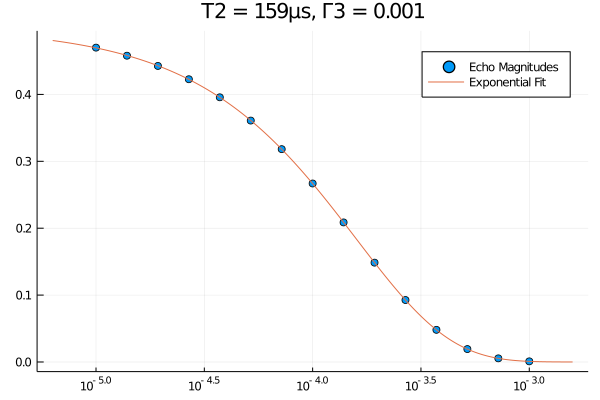

In [58]:
# t2 calculation and plot
@load "t2_check_M_list.jld2" M_list

t2_amps = []

for i = 1:15
    S = M_list[i]
    L = length(S)
    x0 = convert(Int64, round(L/3))
    amp = maximum(broadcast(abs, S[x0:end]))
    push!(t2_amps, amp)
end

using LsqFit
@. model(x,p) = p[1]*exp(-x/p[2])
x = τ
y = t2_amps
p0 = [0.5, 0.0001]
fit = curve_fit(model, x, y, p0)

p = plot(xscale = :log10)
scatter!(τ, t2_amps, label = "Echo Magnitudes")
t = exp10.(LinRange(-5.2, -2.8, 10000))
plot!(t, model(t, coef(fit)), label = "Exponential Fit")
title!("T2 = "*string(convert(Int64, round(coef(fit)[2]*1000000)))*"μs, Γ3 = 0.001")
display(p)